# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [56]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

#### 获取数据

In [57]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


#### 预览部分图像
flatnonzero(a)函数：返回矩阵a中不为0或者为True元素的索引。

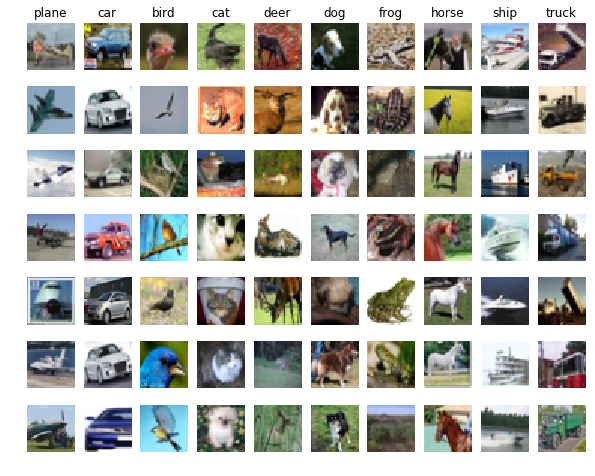

In [58]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

#### 数据集分为3部分，训练集，验证集和测试集

In [59]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation) # 验证集 X_train[49000:50000]为什么不直接这么写呢？
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


#### 将数据转换为1维，即[sample_number,pixel_width* pixel* hight*3]

In [60]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


#### 图像预处理：提取出平均值

[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


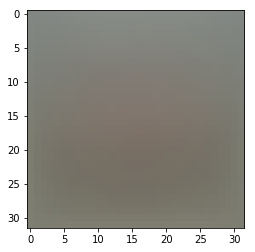

In [61]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image  查看均值图像
plt.show()

#### 图像预处理：去均值

In [62]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [63]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [79]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 #正太分布

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print('loss: %f' % (loss, ))

loss: 9.314197


##### np.random.randn()函数：随机生成一个或多个标准正太分布样本
For random samples from N(\mu, \sigma^2), use:
sigma * np.random.randn(...) + mu

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

##### lambda 匿名函数  冒号前面是参数，后面的函数
lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]

In [65]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 6.728696 analytic: 6.665736, relative error: 4.700500e-03
numerical: 50.395223 analytic: 50.395223, relative error: 5.026086e-12
numerical: -6.271659 analytic: -6.271659, relative error: 2.285498e-11
numerical: 4.974545 analytic: 5.077871, relative error: 1.027876e-02
numerical: 5.826294 analytic: 5.826294, relative error: 5.125313e-11
numerical: -0.628604 analytic: -0.628604, relative error: 4.584272e-10
numerical: -4.264496 analytic: -4.224318, relative error: 4.733132e-03
numerical: -20.102600 analytic: -20.102600, relative error: 2.198828e-11
numerical: 3.570827 analytic: 3.569550, relative error: 1.789082e-04
numerical: 4.880346 analytic: 4.852010, relative error: 2.911450e-03
numerical: 3.879539 analytic: 3.873256, relative error: 8.103686e-04
numerical: -46.649152 analytic: -46.623622, relative error: 2.737048e-04
numerical: -12.309717 analytic: -12.310285, relative error: 2.307193e-05
numerical: -26.427539 analytic: -26.439297, relative error: 2.224086e-04
numerical:

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *解析法与数值法的梯度不一致，这可能是由数值法中h的影响，不需要过多关注，当loss偏导不存在时，梯度不存在.*

In [110]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.314197e+00 computed in 0.416749s
Vectorized loss: 9.314197e+00 computed in 0.009851s
difference: -0.000000


In [111]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.588380s
Vectorized loss and gradient: computed in 0.009467s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [126]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
print(X_train.shape)
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

(49000, 3073)
lr and reg is 0.000000 and 25000, iteration 0 / 1500: loss 793.450076
lr and reg is 0.000000 and 25000, iteration 100 / 1500: loss 473.010199
lr and reg is 0.000000 and 25000, iteration 200 / 1500: loss 287.743312
lr and reg is 0.000000 and 25000, iteration 300 / 1500: loss 175.589756
lr and reg is 0.000000 and 25000, iteration 400 / 1500: loss 107.607554
lr and reg is 0.000000 and 25000, iteration 500 / 1500: loss 66.723957
lr and reg is 0.000000 and 25000, iteration 600 / 1500: loss 42.726504
lr and reg is 0.000000 and 25000, iteration 700 / 1500: loss 27.786051
lr and reg is 0.000000 and 25000, iteration 800 / 1500: loss 19.509595
lr and reg is 0.000000 and 25000, iteration 900 / 1500: loss 13.284781
lr and reg is 0.000000 and 25000, iteration 1000 / 1500: loss 10.307020
lr and reg is 0.000000 and 25000, iteration 1100 / 1500: loss 7.885127
lr and reg is 0.000000 and 25000, iteration 1200 / 1500: loss 7.162277
lr and reg is 0.000000 and 25000, iteration 1300 / 1500: lo

#### 这一步做的时候有问题，loss一直降不下来。原因是self.loss函数，即svm_loss_vectorized计算的loss和grad有问题。
问题出在下面这儿，你敢信！！！浪费了好多时间，气！！ 以后发现结果不对，真的要一步步对代码，很简单的地方也可能出错。

In [118]:
#dW /= num_train
#dW += reg * W
#写成了dW /= num_train + reg * W 
a = 8
b =4
a /= 2 + b
print(a)

1.3333333333333333


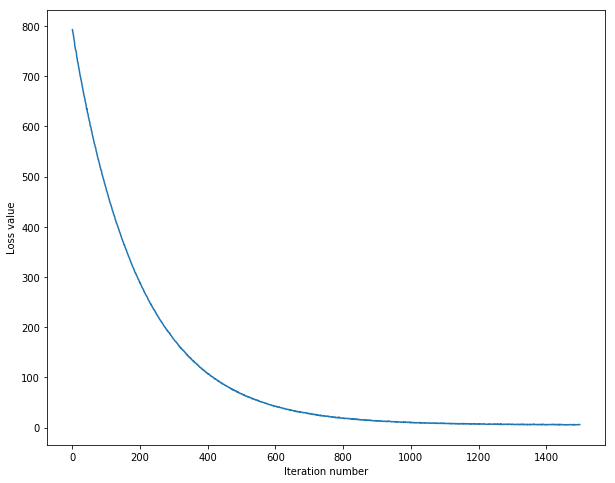

In [113]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [120]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.382490
validation accuracy: 0.399000


In [135]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 2e-7, 1e-8, 1e-6, 1e-5]
regularization_strengths = [2.5e4, 5e4, 1e4, 2e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm_val = LinearSVM()
        svm_val.train(X_train, y_train, learning_rate=lr, 
                      reg=reg,num_iters=1500, verbose=True)
        y_train_pred = svm_val.predict(X_train)
        y_val_pred = svm_val.predict(X_val)
        validation_accuracy = np.mean(y_val == y_val_pred)
        train_accuracy = np.mean(y_train_pred == y_train)
        results[(lr,reg)] = (train_accuracy,validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm_val
            
# results_ = sorted(results.items(),key=lambda item:item[1][1],reverse=False)
# best_val = results_[0][1][1]

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 784.184327
iteration 100 / 1500: loss 465.188572
iteration 200 / 1500: loss 282.690818
iteration 300 / 1500: loss 172.482298
iteration 400 / 1500: loss 105.225753
iteration 500 / 1500: loss 66.325915
iteration 600 / 1500: loss 41.635701
iteration 700 / 1500: loss 27.165649
iteration 800 / 1500: loss 18.597528
iteration 900 / 1500: loss 13.315022
iteration 1000 / 1500: loss 10.149557
iteration 1100 / 1500: loss 7.957537
iteration 1200 / 1500: loss 6.588502
iteration 1300 / 1500: loss 6.853960
iteration 1400 / 1500: loss 6.492830
iteration 0 / 1500: loss 1568.262426
iteration 100 / 1500: loss 570.755136
iteration 200 / 1500: loss 211.434750
iteration 300 / 1500: loss 80.227579
iteration 400 / 1500: loss 32.867397
iteration 500 / 1500: loss 15.469984
iteration 600 / 1500: loss 8.699423
iteration 700 / 1500: loss 7.392779
iteration 800 / 1500: loss 5.980184
iteration 900 / 1500: loss 6.090175
iteration 1000 / 1500: loss 5.545457
iteration 1100 / 1500: loss 5.665561

iteration 1000 / 1500: loss 6.779366
iteration 1100 / 1500: loss 5.410750
iteration 1200 / 1500: loss 5.911996
iteration 1300 / 1500: loss 6.456692
iteration 1400 / 1500: loss 6.081820
iteration 0 / 1500: loss 630.099987
iteration 100 / 1500: loss 16.950571
iteration 200 / 1500: loss 5.950577
iteration 300 / 1500: loss 6.534624
iteration 400 / 1500: loss 6.186024
iteration 500 / 1500: loss 5.871445
iteration 600 / 1500: loss 6.195570
iteration 700 / 1500: loss 6.195038
iteration 800 / 1500: loss 6.635742
iteration 900 / 1500: loss 6.644768
iteration 1000 / 1500: loss 6.327812
iteration 1100 / 1500: loss 6.894247
iteration 1200 / 1500: loss 6.801462
iteration 1300 / 1500: loss 6.897970
iteration 1400 / 1500: loss 7.576490
iteration 0 / 1500: loss 790.642201
iteration 100 / 1500: loss 41.233725
iteration 200 / 1500: loss 36.779847
iteration 300 / 1500: loss 40.732195
iteration 400 / 1500: loss 42.658579
iteration 500 / 1500: loss 45.625629
iteration 600 / 1500: loss 63.355647
iteration 7

#### 关于可视化：
http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.colorbar

##### matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None）
参数：
x, y : input data
s：marksize，园的大小
c：color, sequence, or sequence of color, optional, default: ‘b’，颜色，可以是颜色的string，也可以是一个序列
   当它是序列时，使用cmap参数和norm参数
camp：colormap，颜色映射，只有c为序列时才使用
norm：normalize，将亮度归一化为0.1，只有c为序列时才使用
mark：标记，默认为o，即cicle

##### matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)

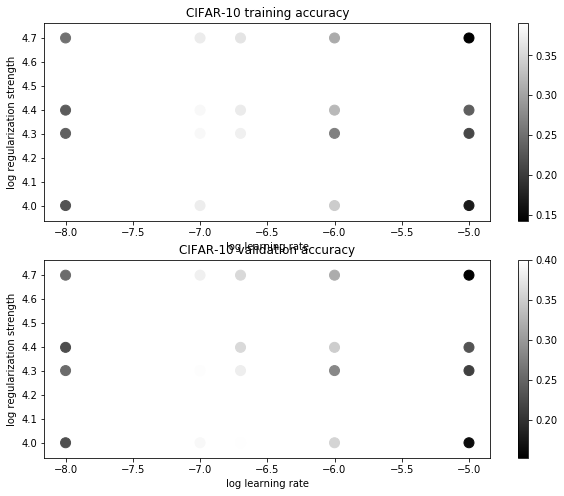

In [141]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]  #x表示key，x[0]表示lr
y_scatter = [math.log10(x[1]) for x in results]  #x表示key，x[1]表示reg
# #[-7.0, -7.0, -7.0, -7.0, 
# -6.698970004336019, -6.698970004336019, -6.698970004336019, -6.698970004336019, 
# #-8.0, -8.0, -8.0, -8.0, 
# -6.0, -6.0, -6.0, -6.0, 
# -5.0, -5.0, -5.0, -5.0]
# [4.3979400086720375, 4.698970004336019, 4.0, 4.301029995663981, 
#  4.3979400086720375, 4.698970004336019, 4.0, 4.301029995663981, 
#  4.3979400086720375, 4.698970004336019, 4.0, 4.301029995663981,
#  4.3979400086720375, 4.698970004336019,4.0, 4.301029995663981, 
#  4.3979400086720375, 4.698970004336019, 4.0, 4.301029995663981]


# plot training accuracy
marker_size = 100  # 圆圈圈的大小
colors = [results[x][0] for x in results] # results[x][0]表示train_accuracy,
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)  #这里color表示的是一个序列，此时会使用camp映射和norm
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [147]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.384000


In [157]:
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
w_min1, w_max1 = np.min(w[:,:,:,1]), np.max(w[:,:,:,1])
print(w_max,w_min)
print(w_max1,w_min1)

0.00015333267566 -0.000164195423503
0.000145036214127 -0.00012343342031


### 很想知道权重的物理意义怎么解释？为什么权重可视化就是对应的图像呢？

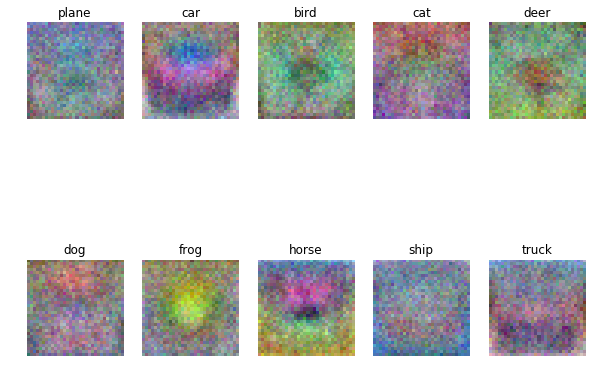

In [160]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min) #对所有的像素归一化，但归一化为什么不分calss呢？
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

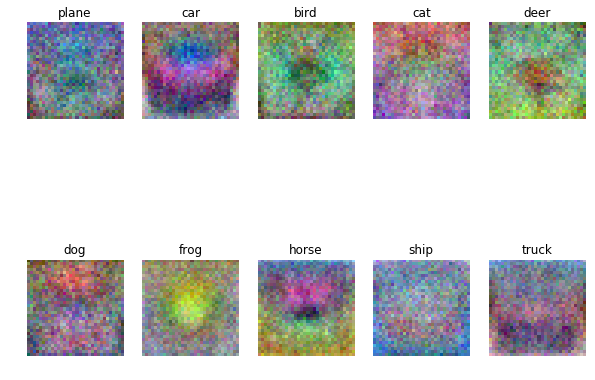

In [163]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    w_min, w_max = np.min(w[:,:,:,i]), np.max(w[:,:,:,i])  
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min) #分类归一化后，好像结果差不多
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *The visualized SVM weights look like they have the average temple(outline) of the corresponding objects, which are what they are expected to respond to. Because the scores is the inner pruduct between the sample and the corresponding weight, if we want to get to higer score in the correct label, the correspoding weight should be more parallel to the sample.*

我的理解是，样本和权重内积得到score，将样本和权重可以看作两个概率分布，为了让score更高，这两个概率分布应该更加相似。则将权重scale到1～255后，其表达的像素就接近于样本所表示的图像。
进一步理解，样本越少，得到的权重可能很容易拟合，但泛化能力就比较差了。